In [1]:
# import os
# import pandas as pd

# # Define the dataset path
# data_path = r"C:\Users\POOJA\.cache\kagglehub\datasets\patrickfleith\nasa-battery-dataset\versions\2\cleaned_dataset"

# # List files in the dataset folder
# files = os.listdir(data_path)
# print("Files in dataset folder:", files)

# # Load one CSV file (Replace 'your_file.csv' with the actual file name)
# csv_file = os.path.join(data_path, files[0])  # Selecting the first file
# df = pd.read_csv(csv_file)

# # Display first few rows
# print(df.head())



# import os
# import pandas as pd

# # New dataset path
# data_path = r"C:\Users\POOJA\OneDrive\Desktop\cleaned_dataset"

# # List all files in the dataset folder
# files = os.listdir(data_path)
# print("Files in dataset folder:", files)

# # Load one CSV file (replace with actual filename if needed)
# csv_file = os.path.join(data_path, files[0])  # Selecting the first file
# df = pd.read_csv(csv_file)

# # Display first few rows
# print(df.head())  # Show first 5 rows
# print(df.columns)  # Show column names




# import os

# # Define dataset path
# data_path = r"C:\Users\POOJA\OneDrive\Desktop\cleaned_dataset"

# # List everything inside cleaned_dataset
# files_and_folders = os.listdir(data_path)
# print("Contents of cleaned_dataset:", files_and_folders)

# # Check if 'data' is a folder
# if "data" in files_and_folders:
#     data_folder = os.path.join(data_path, "data")
#     print("Contents of 'data' folder:", os.listdir(data_folder))



import pandas as pd
import os

# Path to the first CSV file
file_path = r"C:\Users\POOJA\OneDrive\Desktop\cleaned_dataset\data\00001.csv"

# Load the data
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())  

# Show column names
print("Columns in dataset:", df.columns)



   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.246711          0.000252              6.212696        0.0002   
1          4.246764         -0.001411              6.234019        0.0002   
2          4.039277         -0.995093              6.250255        1.0000   
3          4.019506         -0.996731              6.302176        1.0000   
4          4.004763         -0.992845              6.361645        1.0000   

   Voltage_load    Time  
0         0.000   0.000  
1         4.262   9.360  
2         3.465  23.281  
3         3.451  36.406  
4         3.438  49.625  
Columns in dataset: Index(['Voltage_measured', 'Current_measured', 'Temperature_measured',
       'Current_load', 'Voltage_load', 'Time'],
      dtype='object')


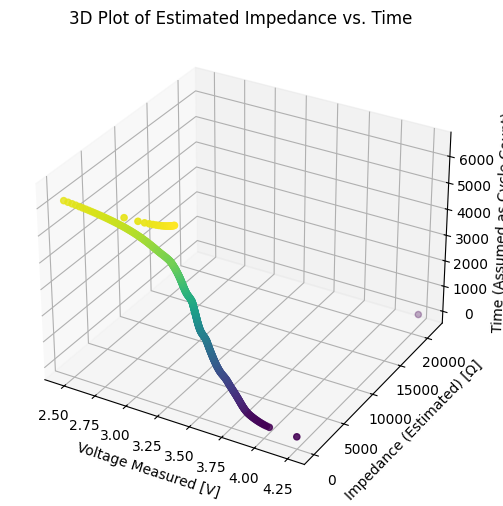

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
file_path = r"C:\Users\POOJA\OneDrive\Desktop\cleaned_dataset\data\00001.csv"
df = pd.read_csv(file_path)

# Calculate impedance (only where Current_load is nonzero)
df = df[df["Current_load"] != 0]  # Remove zero-current values to avoid division errors
df["Impedance"] = df["Voltage_load"] / df["Current_load"]  # Z = V/I

# 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot (assuming Time represents Cycle Count)
ax.scatter(df["Voltage_measured"], df["Impedance"], df["Time"], c=df["Time"], cmap='viridis', marker='o')

# Labels
ax.set_xlabel("Voltage Measured [V]")
ax.set_ylabel("Impedance (Estimated) [Ω]")
ax.set_zlabel("Time (Assumed as Cycle Count)")
ax.set_title("3D Plot of Estimated Impedance vs. Time")

plt.show()


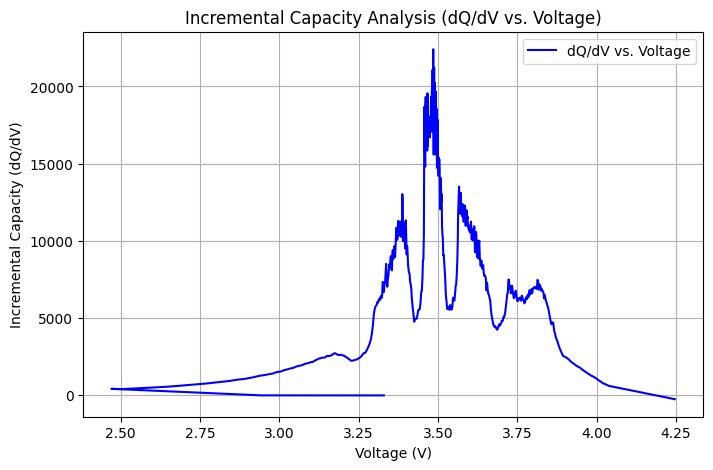

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to dataset
data_path = r"C:\Users\POOJA\OneDrive\Desktop\cleaned_dataset\data"

# Load a sample file (replace with an actual discharge cycle file if needed)
file_path = os.path.join(data_path, "00001.csv")
df = pd.read_csv(file_path)

# Sort data by time (just in case)
df = df.sort_values(by="Time")

# Compute time difference (delta t)
df["delta_t"] = df["Time"].diff().fillna(0)

# Compute cumulative charge (Capacity Q)
df["Capacity"] = (df["Current_measured"] * df["delta_t"]).cumsum()

# Compute dQ/dV using numerical differentiation
df["dQ/dV"] = np.gradient(df["Capacity"], df["Voltage_measured"])

# Plot Incremental Capacity Analysis
plt.figure(figsize=(8, 5))
plt.plot(df["Voltage_measured"], df["dQ/dV"], label="dQ/dV vs. Voltage", color="blue")
plt.xlabel("Voltage (V)")
plt.ylabel("Incremental Capacity (dQ/dV)")
plt.title("Incremental Capacity Analysis (dQ/dV vs. Voltage)")
plt.legend()
plt.grid()
plt.show()


In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Path to dataset
data_path = r"C:\Users\POOJA\OneDrive\Desktop\cleaned_dataset\data"

# Load multiple files (limit to 500 for efficiency)
all_files = sorted([f for f in os.listdir(data_path) if f.endswith('.csv')])[:500]

# Initialize list to store data
df_list = []

# Load and process data
for file in all_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)

    # Remove invalid data (zero current)
    df = df[df["Current_load"] != 0]

    # Compute Estimated Impedance (Z = V/I)
    df["Impedance"] = df["Voltage_load"] / df["Current_load"]

    # Compute Capacity (Q) using integration
    df["delta_t"] = df["Time"].diff().fillna(0)
    df["Capacity"] = (df["Current_measured"] * df["delta_t"]).cumsum()

    # Append relevant columns
    df_list.append(df[["Voltage_measured", "Current_measured", "Temperature_measured", "Impedance", "Capacity"]])

# Combine all data
df_final = pd.concat(df_list, ignore_index=True).dropna()

# Split into Features (X) and Target (y)
X = df_final[["Voltage_measured", "Current_measured", "Temperature_measured", "Impedance"]]
y = df_final["Capacity"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on Test Data
y_pred = model.predict(X_test)

# Evaluate Performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Plot Actual vs Predicted Capacity
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.xlabel("Actual Capacity")
plt.ylabel("Predicted Capacity")
plt.title("Actual vs Predicted Battery Capacity")
plt.grid()
plt.show()


KeyError: 'Current_load'